In [1]:
import umap
import umap.plot
from bokeh.plotting import show, output_notebook
from sklearn import preprocessing
import hdbscan

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.types import *
import pyspark.sql.functions as F

# Quick intro to the UMAP model

Uniform Manifold Approximation and Projection (UMAP) is a manifold learning model for dimension reduction and visualization. Below is a quick summary of what the model try to achieve, i.e. the objective function, refer to the <a href="https://arxiv.org/abs/1802.03426">original paper</a> for more details.

The UMAP model seeks to find a low-dimensional representation of the data that has as similar a fuzzy topological structure of the data as possible. It does so by minimizing the fuzzy set cross entropy between the fuzzy topological representation of the data and that of the low-dimensional representation. 

The fuzzy set cross entropy is defined as follows:

\begin{equation}
\sum_{i \neq j}v_{ij}\log(\frac{v_{ij}}{w_{ij}}) + (1-v_{ij})\log(\frac{1-v_{ij}}{1-w_{ij}})
\end{equation} 
We could think of $v_{ij}$ as the similarity between points $i$ and $j$ in the original space (in practice, this would be the weight of the edge between vertices $i$ and $j$ in a weighted graph), and $w_{ij}$ as the similarity between points $i$ and $j$ in the low-dimensional space. 

For a point $i$ in the original space, its similarity to another point $j$ is defined as:

\begin{equation}
v_{j|i} = \exp(\frac{-\max(0,d(x_i,x_j)-\rho_i)}{\sigma_i})
\end{equation} 

where $d$ is a user-defined distance metric, $\rho_i$ is the distance to the $k$th nearest neighbor of point $i$, and $\sigma_i$ is a normalizing factor. Symmetrization is carried out by defining:
\begin{equation}
v_{ij} = (v_{j|i} + v_{i|j}) - v_{j|i}v_{i|j}
\end{equation} 


For a point $i$ in the low-dimensional space, its similarity to another point $j$ is given by:

\begin{equation}
w_{ij} = (1 + a|| y_i - y_j||_{2}^{2b})^{-1}
\end{equation} 
where $a$ and $b$ are hyperparameters.

# Data preparation using PySpark and Pandas

The raw data we are going to use is MLB's pitch-by-pitch data scraped from the MLB website <a href="https://baseballsavant.mlb.com/">Savant</a>. The parquet file in this repository includes all 3 million pitches from 2014 to 2019. The csv documentation could be found here: https://baseballsavant.mlb.com/csv-docs

### Data Cleaning

In [4]:
sc = SparkSession.builder.getOrCreate()

In [ ]:
baseball = sc.read.parquet('./baseball_savant.parquet')

In [6]:
baseball = baseball.withColumn('pitcher_team',F.when(baseball.inning_topbot == 'Bot', baseball.away_team).otherwise(baseball.home_team))
baseball = baseball.withColumn('batter_team',F.when(baseball.inning_topbot == 'Top', baseball.away_team).otherwise(baseball.home_team))
baseball = baseball.withColumn('game_date',baseball.game_date.cast(DateType()))
baseball = baseball.withColumn('game_year',F.year(baseball.game_date))

window = Window.partitionBy('pitcher','game_year')
baseball = baseball.withColumn('season_total_pitches',F.count('*').over(window))

In [7]:
baseball = baseball.filter(baseball.pitch_type.isNotNull())

In [8]:
baseball.groupby('pitch_type').count().show()

+----------+-------+
|pitch_type|  count|
+----------+-------+
|        FT| 401239|
|        SC|    113|
|        SL| 583237|
|        FC| 202561|
|        EP|    867|
|        FF|1296645|
|        FS|  54809|
|        PO|    630|
|        KC|  89087|
|        IN|   6390|
|        CH| 378308|
|        CU| 299183|
|        FO|    845|
|        UN|     20|
|        KN|  11453|
|        FA|     10|
|        SI| 304441|
+----------+-------+



In [9]:
# keeping pitches that are more common
valid_pitch_type = ['CH','CU','FS','KC','SL','SI','FF','FC','FT']
baseball = baseball.filter(baseball.pitch_type.isin(valid_pitch_type))

### Create arsenal data on which we wish to run UMAP on

Here we are interested in pitchers that pitched in the 2019 season with more than 200 pitches. The spark code produces the average release speed, horizontal movement, vertical movement, and proportion of each pitch type for each pitcher. At the end, we will generate a 36-dimensional dataframe that will be fed into UMAP.

In [10]:
arsenal = baseball.select('pitch_type','game_year','player_name','pitcher','p_throws','pitcher_team','season_total_pitches','pitcher','pfx_x','pfx_z','release_speed')

In [11]:
arsenal = arsenal.filter('game_year = 2019 and season_total_pitches > 200').groupBy('pitcher','pitch_type','pitcher_team').\
agg(F.first('player_name').alias('player_name'),
    F.first('p_throws').alias('p_throws'),
    F.avg('release_speed').alias('avg_speed'), 
    F.avg('pfx_z').alias('avg_z'),
    F.avg('pfx_x').alias('avg_x'),
    F.count('*').alias('count'))

In [12]:
window = Window.partitionBy('pitcher','pitcher_team')
arsenal = arsenal.withColumn('proportion', F.col('count')/F.sum('count').over(window))

In [13]:
# convert from a spark dataframe to a Pandas dataframe
arsenal = arsenal.toPandas()

In [14]:
# data for Masahiro Tanaka (long format, we will transform it to wide format later)
arsenal[arsenal.player_name == 'Masahiro Tanaka']

,pitcher,pitch_type,pitcher_team,player_name,p_throws,avg_speed,avg_z,avg_x,count,proportion
2936,547888,SI,NYY,Masahiro Tanaka,R,90.335294,0.725872,-1.235809,136,0.045546
2937,547888,SL,NYY,Masahiro Tanaka,R,83.248861,0.108844,0.548934,1097,0.367381
2938,547888,FC,NYY,Masahiro Tanaka,R,87.460870,0.672999,-0.141720,46,0.015405
2939,547888,FS,NYY,Masahiro Tanaka,R,86.724876,0.428213,-1.064891,808,0.270596
2940,547888,CU,NYY,Masahiro Tanaka,R,76.069231,-0.750867,0.770970,91,0.030476
2941,547888,FF,NYY,Masahiro Tanaka,R,91.439851,1.334656,-0.840529,808,0.270596


In [15]:
# sometimes the MLB classify pitches incorrectly, we want to get rid of those records
arsenal2 = arsenal[arsenal.proportion > 0.01]

In [16]:
# transform the data so that each row now represents a pitcher (wide format)
df = arsenal2.pivot_table(index = ['pitcher','player_name','p_throws','pitcher_team'], columns = 'pitch_type', values = ['avg_x','avg_z','avg_speed','proportion'])
df.columns = [x[0] + '_' + x[1] for x in df.columns]
df.reset_index(inplace = True)
df.fillna(0,inplace = True)

In [17]:
pd.set_option('display.max_columns', None)

In [18]:
df.sample(5)

,pitcher,player_name,p_throws,pitcher_team,avg_speed_CH,avg_speed_CU,avg_speed_FC,avg_speed_FF,avg_speed_FS,avg_speed_FT,avg_speed_KC,avg_speed_SI,avg_speed_SL,avg_x_CH,avg_x_CU,avg_x_FC,avg_x_FF,avg_x_FS,avg_x_FT,avg_x_KC,avg_x_SI,avg_x_SL,avg_z_CH,avg_z_CU,avg_z_FC,avg_z_FF,avg_z_FS,avg_z_FT,avg_z_KC,avg_z_SI,avg_z_SL,proportion_CH,proportion_CU,proportion_FC,proportion_FF,proportion_FS,proportion_FT,proportion_KC,proportion_SI,proportion_SL
144,518876,Merrill Kelly,R,ARI,86.002010,80.589241,89.859184,91.957324,0.0,0.000000,0.0,91.546341,0.000000,-1.047555,0.796450,0.176486,-0.387549,0.0,0.000000,0.0,-1.154523,0.000000,1.116711,-1.040778,0.895485,1.274787,0.0,0.000000,0.0,0.734998,0.000000,0.134369,0.213369,0.181972,0.373396,0.0,0.000000,0.0,0.096894,0.000000
587,641838,Kevin McCarthy,R,KC,83.879793,82.345833,0.000000,88.900000,0.0,0.000000,0.0,91.071545,83.389655,-1.247969,0.244396,0.000000,-0.192759,0.0,0.000000,0.0,-1.177328,0.024866,0.334560,0.178350,0.000000,0.666853,0.0,0.000000,0.0,0.358008,0.297627,0.219818,0.027335,0.000000,0.159453,0.0,0.000000,0.0,0.560364,0.033030
365,596027,Dillon Maples,R,CHC,0.000000,84.811765,0.000000,96.733824,0.0,96.818182,0.0,0.000000,89.478014,0.000000,1.099596,0.000000,-0.430334,0.0,-0.911040,0.0,0.000000,1.053154,0.000000,-1.219996,0.000000,0.913305,0.0,0.688744,0.0,0.000000,-0.176859,0.000000,0.071730,0.000000,0.286920,0.0,0.046414,0.0,0.000000,0.594937
518,621389,Ty Blach,L,SF,79.475000,75.766667,85.000000,0.000000,0.0,0.000000,0.0,90.489610,81.928571,1.480195,-0.799699,0.100955,0.000000,0.0,0.000000,0.0,1.356754,-0.316563,0.467096,-0.994453,0.427241,0.000000,0.0,0.000000,0.0,0.870515,0.010473,0.251969,0.070866,0.015748,0.000000,0.0,0.000000,0.0,0.606299,0.055118
385,605130,Scott Barlow,R,KC,0.000000,77.182081,0.000000,94.134505,0.0,93.835577,0.0,0.000000,83.763781,0.000000,1.244309,0.000000,-0.327209,0.0,-1.064226,0.0,0.000000,0.696746,0.000000,-1.000788,0.000000,1.131643,0.0,0.605932,0.0,0.000000,-0.288613,0.000000,0.133077,0.000000,0.350000,0.0,0.080000,0.0,0.000000,0.435385


In [19]:
df_umap = df.drop(['pitcher','player_name','p_throws','pitcher_team'],axis = 1)

In [20]:
# Scale each column by its maximum absolute value
cols_to_scale = [col for col in df if col.startswith('avg')]
preprocessor = preprocessing.MaxAbsScaler().fit(df_umap[cols_to_scale])
df_umap[cols_to_scale] = preprocessor.transform(df_umap[cols_to_scale])

In [21]:
# 36-dimensional data that will be fed into the UMAP algorithm.
df_umap.iloc[190]

avg_speed_CH     0.000000
avg_speed_CU     0.928290
avg_speed_FC     0.939670
avg_speed_FF     0.975593
avg_speed_FS     0.953298
avg_speed_FT     0.000000
avg_speed_KC     0.000000
avg_speed_SI     0.000000
avg_speed_SL     0.918602
avg_x_CH         0.000000
avg_x_CU         0.378997
avg_x_FC         0.061649
avg_x_FF        -0.591736
avg_x_FS        -0.489777
avg_x_FT         0.000000
avg_x_KC         0.000000
avg_x_SI         0.000000
avg_x_SL         0.321928
avg_z_CH         0.000000
avg_z_CU        -0.457214
avg_z_FC         0.558999
avg_z_FF         0.633422
avg_z_FS         0.102651
avg_z_FT         0.000000
avg_z_KC         0.000000
avg_z_SI         0.000000
avg_z_SL         0.035081
proportion_CH    0.000000
proportion_CU    0.174842
proportion_FC    0.225475
proportion_FF    0.432753
proportion_FS    0.135285
proportion_FT    0.000000
proportion_KC    0.000000
proportion_SI    0.000000
proportion_SL    0.031646
Name: 190, dtype: float64

# Apply UMAP on pitcher arsenal

Here we apply the UMAP algorithm and project the data onto a 2 dimensional space. There are two hyper-parameters: n_neighbors, the number of nearest neighbors when constructing the graph in the original space, and min_dist, the minimum distance between points in the low-dimensional embedding space. <br>
Increasing n_neighbors would let us preserve more the global structure of the data, while decreasing n_neighbors let us focus on the local structure of the data. The second hyper-parameter min_dist is more of a aesthetic hyper-paramter.

In [22]:
# N_components is the dimension that the data is projected onto
N_COMPONENTS = 2
METRIC = 'cosine'
transformer = umap.UMAP(n_components = N_COMPONENTS, random_state = 0,n_neighbors=30,min_dist=0.0, metric = METRIC).fit(df_umap)
embedding = transformer.transform(df_umap)

# Apply HDBSCAN on the UMAP embeddings

After learning a low-dimensional representation for the pitcher data, we could apply a clustering algorithm on the embeddings to detect pitcher clusters. In particular, I chose HDBSCAN. HDBSCAN is a hierarchical density-based clustering algorithm. Unlike K-Means, HDBSCAN works well with clusters having varying densities and shapes. The main hyper-parameter we would control is the minimum cluster size, which I set to be 15.

The HDBSCAN gives us 17 clusters:

In [23]:
# Fit HDBSCAN with minimum cluster size 15
clusterer = hdbscan.HDBSCAN(min_cluster_size=15)
clusterer.fit(embedding)
# number of clusters that are detected by HDBSCAN
clusterer.labels_.max()+1

17

In [24]:
embedding_dat = pd.DataFrame(np.column_stack([embedding,clusterer.labels_,df[['player_name','p_throws','pitcher_team']]]),
                             columns = ['x{}'.format(i) for i in range(1,N_COMPONENTS+1)]+['cluster','player_name','p_throws','team'])\
                            .sort_values('cluster')

In [25]:
embedding_dat.sample(10)

,x1,x2,cluster,player_name,p_throws,team
638,2.42754,9.34763,12,Jack Flaherty,R,STL
125,0.98935,9.56918,11,Juan Nicasio,R,PHI
74,-1.47851,13.3971,7,Jhoulys Chacin,R,BOS
591,3.78699,4.43672,13,Emilio Pagan,R,TB
587,8.14456,7.95036,10,Kevin McCarthy,R,KC
200,11.4319,0.514317,1,Jay Jackson,R,MIL
496,6.31152,3.53185,14,Hunter Wood,R,CLE
529,2.95036,12.5205,4,Luis Castillo,R,CIN
177,2.37082,5.1517,-1,Shawn Armstrong,R,BAL
261,0.668301,0.457897,5,Tyler Skaggs,L,LAA


# Visualization of the embeddings

## Points colored by handedness:
We are able to separate the left-handed and right-handed pitchers pretty well.

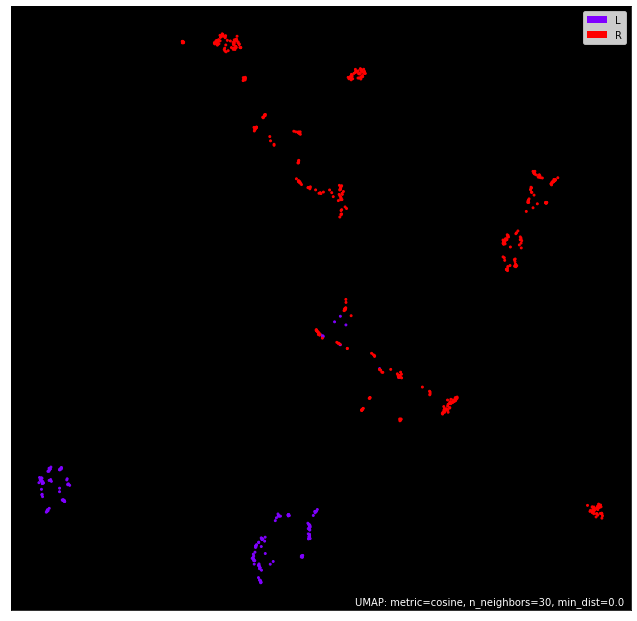

In [26]:
umap.plot.points(transformer, labels = df.p_throws, theme = 'fire')

## Points colored by cluster membership:

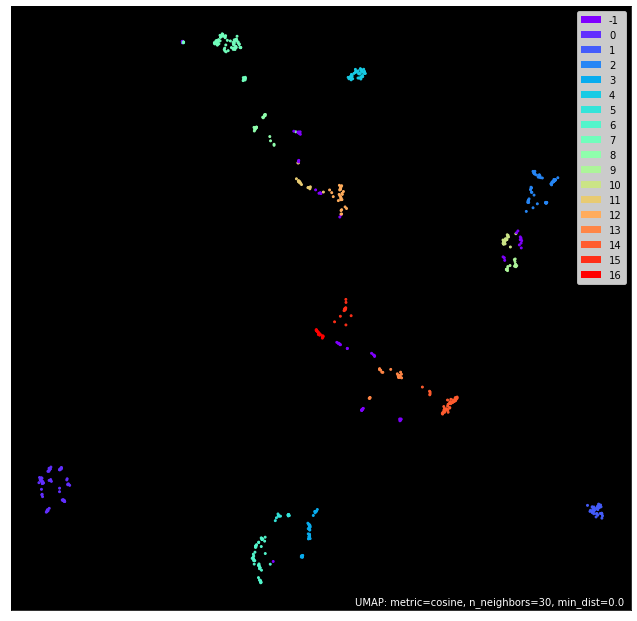

In [27]:
# -1 represents points that are viewed as noise by the HDBSCAN
umap.plot.points(transformer, labels = clusterer.labels_, theme = 'fire')

# Conclusion

By applying UMAP, we were able to learn a low-dimensional latent represenation of MLB pitchers. We successfully visualized a 36-dimensional pithcer arsenal data and were able to detect potential pitcher clusters. Utilizing the cluster information, one could then investigate how a batter play against different types of pitchers. It thus provides useful insights into how a manager could design and optimize a batting lineup.